# Load Libraries and Functions

In [1]:
import os
import requests
import pandas as pd
import json
import time
import random
from datetime import datetime, timedelta
import numpy as np 
import xml.etree.ElementTree as ET

import pymysql as mysql
import mysql.connector
import warnings
import matplotlib.pyplot as plt
import csv
from nltk.tokenize import word_tokenize

import pyodbc
import sqlite3
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy import event
from tabulate import tabulate
import plotly.express as px
import seaborn as sns
from string import punctuation
import string
import nltk
from collections import OrderedDict
from nltk.tokenize import word_tokenize
from pandas import json_normalize  


#nltk.download('punkt')
#nltk.download('stopwords')
warnings.filterwarnings('ignore')


from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.util import ngrams

from nltk.corpus import stopwords
from string import punctuation
punctuation = set(punctuation)
punctuation.update({'_', '-','‘'})


# mysql password
PASSWORD = "password"

import nbimporter
from Functions import process_text, add_sequential_index, process_label_text, remove_duplicates_nan
from Functions import classify_product_type, nan_info, plot_character_length, convert_to_years

# FDA Data

## API Request for Historical Text Documents

https://open.fda.gov/apis/other/historicaldocument/

In [2]:
# OpenFDA API endpoint for fetching historical documents
BASE_URL = 'https://api.fda.gov/other/historicaldocument.json'

# Parameters for the API request
params = {
    'limit': 1000,  # Adjust the limit as needed
    'skip': 0      # Starting point for fetching records
}

# Function to pause execution to avoid overwhelming the server
def pause_execution():
    time.sleep(5 + 10 * random.random())

# Function to fetch data from the OpenFDA API
def fetch_data(max_requests):
    documents = []
    request_count = 0  # Initialize request counter
    
    while request_count < max_requests:
        response = requests.get(BASE_URL, params=params)
        print(f"Requesting data with params: {params}")  # Debugging statement
        print(f"Response status code: {response.status_code}")  # Debugging statement

        if response.status_code != 200:
            print(f"Failed to fetch data: {response.status_code}")  # Debugging statement
            break
        
        data = response.json()
        results = data.get('results', [])
        if not results:
            print("No more results found.")  # Debugging statement
            break

        for item in results:
            doc_type = item.get('doc_type', 'N/A')
            year = item.get('year', 'N/A')
            text = item.get('text', 'N/A')
            document = {'doc_type': doc_type, 'year': year, 'text': text}
            if document not in documents:
                documents.append(document)
        
        params['skip'] += params['limit']
        request_count += 1  # Increment request counter
        pause_execution()

    return documents

# Fetch the data
documents = fetch_data(max_requests=1)

# Save the data to a CSV file
documents_df = pd.DataFrame(documents)
documents_df.head()

Requesting data with params: {'limit': 1000, 'skip': 0}
Response status code: 200


,doc_type,year,text
0,pr,2006,FDA NEWS RELEASE\nFOR IMMEDIATE RELEASE\n\nFeb...
1,pr,2006,FDA NEWS RELEASE\nFOR IMMEDIATE RELEASE\n\nFeb...
2,talk,1991,I FOOD _-AND DRUG ADMINISTRATION ‘ 'i\nU. S. D...
3,pr,1934,iNFORMATION FOR THE PRESS\n\nu 8. DEPARTMENT O...
4,pr,1975,\n\nU. S. DEPARTMENT OF HEALTH. EDUCATION. AN...


In [3]:
documents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   doc_type  1000 non-null   object
 1   year      1000 non-null   int64 
 2   text      1000 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.6+ KB


In [4]:
# Save csv file to data library
#csv_file_path = 'DataLibrary/raw_documents.csv'
#documents_df.to_csv(csv_file_path, index=False)

# Save the data to a JSON file
#json_file_path = 'DataLibrary/raw_documents.json'
#with open(json_file_path, 'w') as json_file:
#    json.dump(documents, json_file, indent=4)

#print(f"Data saved to {csv_file_path} and {json_file_path}")

## API Request for Adverse Events Data

https://open.fda.gov/apis/drug/event/

In [5]:
# OpenFDA API endpoint for fetching drug event data
BASE_URL = 'https://api.fda.gov/drug/event.json'

# Parameters for the API request
params = {
    'limit': 1000,  # Maximum limit per request
    'skip': 0      # Starting point for fetching records
}

# Function to pause execution to avoid overwhelming the server
def pause_execution():
    time.sleep(5 + 10 * random.random())

# Function to fetch data from the OpenFDA API
def fetch_data(max_requests):
    events = []
    request_count = 0  # Initialize request counter
    
    while request_count < max_requests:
        response = requests.get(BASE_URL, params=params)
        print(f"Requesting data with params: {params}")  # Debugging statement
        print(f"Response status code: {response.status_code}")  # Debugging statement

        if response.status_code != 200:
            print(f"Failed to fetch data: {response.status_code}")  # Debugging statement
            break
        
        data = response.json()
        results = data.get('results', [])
        if not results:
            print("No more results found.")  # Debugging statement
            break

        for item in results:
            events.append(item)
        
        params['skip'] += params['limit']
        request_count += 1  # Increment request counter
        pause_execution()

    return events

# Fetch the data
events = fetch_data(max_requests=2)

# Convert the data to a pandas DataFrame
events_df = pd.json_normalize(events)

# Display the first few rows of the DataFrame
events_df.head()

Requesting data with params: {'limit': 1000, 'skip': 0}
Response status code: 200
Requesting data with params: {'limit': 1000, 'skip': 1000}
Response status code: 200


,safetyreportid,transmissiondateformat,transmissiondate,serious,seriousnessdeath,receivedateformat,receivedate,receiptdateformat,receiptdate,fulfillexpeditecriteria,...,seriousnessother,occurcountry,patient.patientagegroup,seriousnesshospitalization,patient.summary.narrativeincludeclinical,seriousnesslifethreatening,patient.patientweight,primarysource.literaturereference,seriousnesscongenitalanomali,authoritynumb
0,5801206-7,102,20090109,1,1,102,20080707,102,20080625,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10003300,102,20141002,1,NaN,102,20140306,102,20140306,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10003301,102,20141002,1,NaN,102,20140228,102,20140228,2,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10003302,102,20141002,2,NaN,102,20140312,102,20140312,2,...,NaN,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10003304,102,20141212,2,NaN,102,20140312,102,20140424,2,...,NaN,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 42 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   safetyreportid                               2000 non-null   object 
 1   transmissiondateformat                       2000 non-null   object 
 2   transmissiondate                             2000 non-null   object 
 3   serious                                      2000 non-null   object 
 4   seriousnessdeath                             145 non-null    object 
 5   receivedateformat                            2000 non-null   object 
 6   receivedate                                  2000 non-null   object 
 7   receiptdateformat                            2000 non-null   object 
 8   receiptdate                                  2000 non-null   object 
 9   fulfillexpeditecriteria                      2000 non-null   object 
 10  

#### Examine Variables of Interest

In [7]:
# 2 - Yes, 1 - No
events_df['fulfillexpeditecriteria'].value_counts()

2    1131
1     869
Name: fulfillexpeditecriteria, dtype: int64

In [8]:
# 5 - Consumer/NonHealth, 4 - Lawyer, 3 - Health Professional, 4 - Pharmacist, 5 - MD
events_df['primarysource.qualification'].value_counts()

5    1084
1     412
3     288
4     151
2      57
Name: primarysource.qualification, dtype: int64

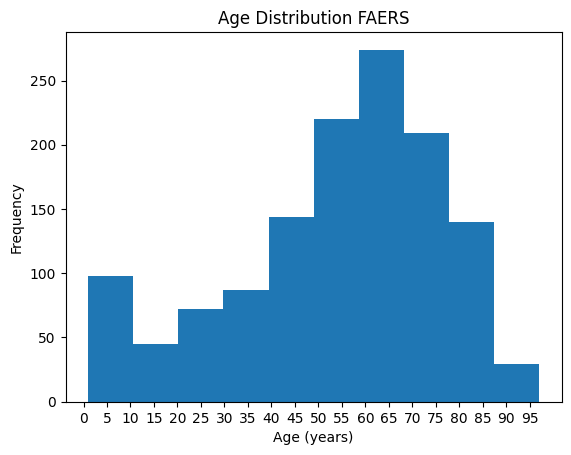

In [9]:
# Distribution of Age
plt.hist(events_df['patient.patientonsetage'].astype('float'))
ticks = np.arange(0, 100, 5)  # Customize this range as needed
plt.xticks(ticks)
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.title('Age Distribution FAERS')
plt.show()

In [10]:
# Ages come in different units, need to standardize to years
events_df['patient.patientonsetageunit'].value_counts()

801    1313
804       4
802       1
Name: patient.patientonsetageunit, dtype: int64

In [11]:
# Some reports have more than one version, retain most recent versions only
events_df['safetyreportversion'].value_counts()

1     1040
2      556
3      337
4       37
5       10
6        6
7        6
8        3
9        2
11       1
12       1
Name: safetyreportversion, dtype: int64

In [12]:
# Can see manufacturers where most reports were duplicated
events_df['reportduplicate.duplicatesource'].value_counts()

GILEAD                  458
PFIZER                  320
MERCK                   175
INCYTE                  166
ABBVIE                  160
NOVARTIS                139
BAXTER                   82
GLAXOSMITHKLINE          75
TEVA                     51
BOEHRINGER INGELHEIM     47
BAYER                    45
SANDOZ                   32
CELGENE                  29
MYLAN                    29
JANSSEN                  20
LUNDBECK                 18
WATSON                   18
BRISTOL MYERS SQUIBB     15
AVENTIS                  11
GE HEALTHCARE            11
AMGEN                    11
ACTAVIS                   8
ASTRAZENECA               7
ALEXION                   7
ROCHE                     6
ACTELION                  6
EMD SERONO INC            6
ACORDA                    6
FOREST                    6
PURDUE                    4
VERTEX                    4
OTSUKA                    3
CUBIST                    3
ETHICON                   3
PHARMACYCLICS             2
JOHNSON AND JOHNSON 

In [13]:
# Save the data to a JSON file
#json_file_path = 'DataLibrary/raw_events.json'
#with open(json_file_path, 'w') as json_file:
#    json.dump(events, json_file, indent=4)

# Save the data to a CSV file
#csv_file_path = 'DataLibrary/raw_events.csv'
#events_df.to_csv(csv_file_path, index=False)

#print(f"Data saved to {csv_file_path} and {json_file_path}")

## API Request for Drug Labels

https://open.fda.gov/apis/drug/label/

In [6]:
# OpenFDA API endpoint for fetching drug label data
BASE_URL = 'https://api.fda.gov/drug/label.json'

# Parameters for the API request
params = {
    'limit': 1000,  # Maximum limit per request
    'skip': 0      # Starting point for fetching records
}

# Function to pause execution to avoid overwhelming the server
def pause_execution():
    time.sleep(5 + 10 * random.random())

# Function to fetch data from the OpenFDA API
def fetch_data(max_requests):
    labels = []
    request_count = 0  # Initialize request counter
    
    while request_count < max_requests:
        response = requests.get(BASE_URL, params=params)
        print(f"Requesting data with params: {params}")  # Debugging statement
        print(f"Response status code: {response.status_code}")  # Debugging statement

        if response.status_code != 200:
            print(f"Failed to fetch data: {response.status_code}")  # Debugging statement
            break
        
        data = response.json()
        results = data.get('results', [])
        if not results:
            print("No more results found.")  # Debugging statement
            break

        for item in results:
            labels.append(item)
        
        params['skip'] += params['limit']
        request_count += 1  # Increment request counter
        pause_execution()

    return labels

# Fetch the data
labels = fetch_data(max_requests=2)

# Convert the data to a pandas DataFrame
labels_df = pd.json_normalize(labels)

# Display the first few rows of the DataFrame
labels_df.head()

Requesting data with params: {'limit': 1000, 'skip': 0}
Response status code: 200
Requesting data with params: {'limit': 1000, 'skip': 1000}
Response status code: 200


,effective_time,inactive_ingredient,purpose,keep_out_of_reach_of_children,warnings,questions,spl_product_data_elements,version,dosage_and_administration,pregnancy_or_breast_feeding,...,components,intended_use_of_the_device,mechanism_of_action_table,general_precautions_table,drug_and_or_laboratory_test_interactions_table,accessories,ask_doctor_table,when_using_table,ask_doctor_or_pharmacist_table,do_not_use_table
0,20210902,[INACTIVE INGREDIENTS Sucrose],"[USES USES: Temporary Relief - Acne, Boils* * ...",[Keep this and all medication out of reach of ...,[WARNINGS This product is to be used for self-...,[QUESTIONS OR COMMENTS www.Rxhomeo.com | 1.888...,[SILICEA SILICEA SUCROSE SILICON DIOXIDE SILIC...,2,"[DOSAGE Adults- Take 4 or 6 Pellets by mouth, ...","[As with any drug, if you are pregnant, or nur...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20150109,"[INGREDIENTS: TALC, POLYMETHYL METHACRYLATE, V...",[Purpose Sunscreen],[Keep out of reach of children If product is s...,[Warnings For external use only.],NaN,[CHANTECAILLE PROTECTION NATURELLE BRONZE SPF ...,4,[Directions Protection Naturelle SPF 46 PA+++ ...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20230802,[INACTIVE INGREDIENTS Sucrose/Lactose],[USES To relieve the symptoms of itching.],[KEEP OUT OF REACH OF CHILDREN Keep this and a...,[STOP USE AND ASK DOCTOR If symptoms persist/w...,NaN,[Mezereum DAPHNE MEZEREUM BARK SUCROSE LACTOSE...,3,[DIRECTIONS Adults: Dissolve 3 to 5 under the ...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20230905,NaN,NaN,NaN,[WARNINGS NOT FOR INJECTION. Ofloxacin ophthal...,NaN,[Ofloxacin Ofloxacin OFLOXACIN OFLOXACIN Sodiu...,7,[DOSAGE AND ADMINISTRATION The recommended dos...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20230403,NaN,NaN,NaN,NaN,NaN,[Naproxen Naproxen NAPROXEN NAPROXEN CROSCARME...,27,[2 DOSAGE AND ADMINISTRATION Use the lowest ef...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
pd.set_option('display.max_info_columns', 140)
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 140 columns):
 #    Column                                                            Non-Null Count  Dtype 
---   ------                                                            --------------  ----- 
 0    effective_time                                                    2000 non-null   object
 1    inactive_ingredient                                               1218 non-null   object
 2    purpose                                                           1190 non-null   object
 3    keep_out_of_reach_of_children                                     1186 non-null   object
 4    warnings                                                          1586 non-null   object
 5    questions                                                         659 non-null    object
 6    spl_product_data_elements                                         1999 non-null   object
 7    version                        

In [16]:
# Save the data to a JSON file
#json_file_path = 'DataLibrary/raw_labels.json'
#with open(json_file_path, 'w') as json_file:
#    json.dump(labels, json_file, indent=4)

# Save the data to a CSV file
#csv_file_path = 'DataLibrary/raw_labels.csv'
#labels_df.to_csv(csv_file_path, index=False)

#print(f"Data saved to {csv_file_path} and {json_file_path}")

# National Library of Medicine - Standardized Drug Names and Information

## API Request for RxNorm

https://lhncbc.nlm.nih.gov/RxNav/APIs/RxNormAPIs.html

In [17]:
# Base URL for RxTerms API to get all drug names
#BASE_URL = 'https://rxnav.nlm.nih.gov/REST/RxTerms/rxcui'

# Function to pause execution to avoid overwhelming the server
#def pause_execution():
#    time.sleep(1 + 2 * random.random())

# Function to fetch data from the RxTerms API
#def fetch_data(max_requests):
#    drugs = []
#    start_rxcui = 1  # Starting RxCUI for the search
#    step = 500      # Step size to iterate through RxCUIs
#    request_count = 0  # Initialize request counter

#    while request_count < max_requests:
#        batch_drugs = []
#        for i in range(start_rxcui, start_rxcui + step):
#            url = f"{BASE_URL}/{i}/allinfo.json"
#            response = requests.get(url)

#            if response.status_code != 200:
#                print(f"Failed to fetch data: {response.status_code}")  # Debugging statement
#                continue

#            if response.content.strip():  # Check if the response content is not empty
#                data = response.json()
#                properties = data.get('rxtermsProperties', {})

#                if properties:
#                    if properties.get('marketed', '').lower() == 'true':
#                        properties['rxcui'] = i
#                        batch_drugs.append(properties)

#        drugs.extend(batch_drugs)  # Add the batch results to the main list
#        print(f"Processed batch starting with RxCUI: {start_rxcui}")  # Debugging statement for each batch

        # Update the start_rxcui for the next batch
 #       start_rxcui += step
#      request_count += 1  # Increment request counter

        # Break condition to stop if no more data in the batch
#        if not batch_drugs:
#            break

#        pause_execution()

#    return drugs

# Fetch the data
#drugs = fetch_data(max_requests=1)

# Convert the data to a pandas DataFrame
#drugs_df = pd.DataFrame(drugs)

# Display the first few rows of the DataFrame
#drugs_df.head()

In [18]:
# Save the data to a JSON file
#json_file_path = 'DataLibrary/rxterms_drugs.json'
#with open(json_file_path, 'w') as json_file:
#    json.dump(drugs, json_file, indent=4)

# Save the data to a CSV file
#csv_file_path = 'DataLibrary/rxterms_drugs.csv'
#drugs_df.to_csv(csv_file_path, index=False)

#print(f"Data saved to {csv_file_path} and {json_file_path}")

# ADReCS Database for Standardized Drug and ADR Term Labeling

In [11]:
# load in static files
adrecs_drug = pd.read_excel('ADReCS/Drug_information_v3.3.xlsx')
adrecs_drug.head()

,DRUG_ID,DRUG_NAME,DRUG_SYNONYMS,DrugBank_ID,PubChem_ID,MESH_ID,KEGG_ID,TTD_ID
0,BADD_D00001,"1,2-hexanediol","1,2-hexanediol",DB14108,94335,C119102,Not Available,Not Available
1,BADD_D00002,2-hydroxy-3-phenylpropanoic acid,"3-phenyllactic acid | 3-phenyllactic acid, mon...",Not Available,3848,C017648,Not Available,Not Available
2,BADD_D00003,2-phenylbutyric acid,2-phenylbutyric acid | 2-phenylbutanoic acid,Not Available,7012,C039714,Not Available,Not Available
3,BADD_D00004,2-[1-methyl-5-(4-methylbenzoyl)pyrrol-2-yl]ace...,"Tolmetin | Tolectin | Tolmetin Sodium, Anhydro...",DB00500,5508,D014046,D00158; D02355,D09BHB
4,BADD_D00005,4-oxo-3-(3-oxo-1-phenylbutyl)chromen-2-olate,Warfarin | 4-Hydroxy-3-(3-oxo-1-phenylbutyl)-2...,DB00682,23690541,D014859,D00564; D08682; D01280,D0E3OF


In [9]:
adrecs_ont = pd.read_excel('ADReCS/ADR_ontology_v3.3.xlsx')
adrecs_ont.head()

,ADRECS_ID,ADR_ID,ADR_TERM,ADR_SYNONYMS,MEDDRA_CODE
0,01,BADD_A00503,Blood and lymphatic system disorders,Not Available,10005329
1,01.01,BADD_A06244,Coagulopathies and bleeding diatheses (excl th...,Not Available,10064477
2,01.01.01,BADD_A00960,Coagulation factor deficiencies,Not Available,10009737
3,01.01.01.001,BADD_A02211,Hypoprothrombinaemia,Exaggerated hypoprothrombinaemia | Hypoprothro...,10021085
4,01.01.01.002,BADD_A05294,Acquired haemophilia,Acquired haemophilia | Acquired hemophilia | A...,10053745


In [12]:
# 2601 drugs, and 15317 ADR terms
adrecs_drug.shape, adrecs_ont.shape

((2601, 8), (15317, 5))

# Medicaid 

## API Drug Prices - NADAC - 2024 Report 

https://data.medicaid.gov/dataset/99315a95-37ac-4eee-946a-3c523b4c481e#data-table

In [13]:
# Base URL for the Medicaid API for NADAC data
BASE_URL = 'https://data.medicaid.gov/api/1/datastore/sql'

# Initial SQL query to fetch data with a limit of 500 and initial offset 0
# Queries 2024 Database
query_template = '[SELECT * FROM f3b5cf6b-07cc-5f75-8d7b-0a1090b3f7e9][LIMIT 500 OFFSET {}]'

# Function to pause execution to avoid overwhelming the server
def pause_execution():
    # Pause execution for a random time between 1 and 3 seconds to avoid hitting the server too hard
    time.sleep(1 + 2 * random.random())

# Function to fetch data from the Medicaid API in batches
def fetch_nadac_data():
    all_data = []  # Initialize an empty list to store all fetched data
    offset = 0  # Starting offset for pagination
    max_requests = 2  # Maximum number of requests to fetch 1000 records
    
    for _ in range(max_requests):  # Loop to fetch data in batches
        # Modify the query to include the current offset for pagination
        query = query_template.format(offset)
        params = {'query': query}  # Set the parameters for the API request

        response = requests.get(BASE_URL, params=params)  # Send the request to the API
        print(f"Requesting data with offset: {offset}")  # Debugging statement to show current offset
        print(f"Response status code: {response.status_code}")  # Debugging statement to show response status

        if response.status_code != 200:  # Check if the request was unsuccessful
            print(f"Failed to fetch data: {response.status_code}")  # Debugging statement for error status
            try:
                error_details = response.json()
                print(f"Error message: {error_details.get('message', 'No message provided')}")  # Print the error message
                print(f"Error details: {error_details.get('data', 'No additional data provided')}")  # Print additional error details
            except ValueError:
                print("Failed to decode JSON error response.")  # Debugging statement for JSON error
            break  # Exit the loop if there was an error

        try:
            data = response.json()  # Parse the response JSON
            #print(f"Raw response data: {data}")  # Debugging statement to show raw response data
            
            if not isinstance(data, list):  # Check if the response is an array
                print("Expected a list but got a different structure.")
                break

            if not data:  # Check if the list is empty
                print("No more results found.")  # Debugging statement to indicate no more data
                break  # Exit the loop if no more data is found

            all_data.extend(data)  # Append the fetched data to the main list
            offset += len(data)  # Increment the offset by the number of records fetched
            print(f"Fetched {len(data)} records. Total so far: {len(all_data)}")  # Debugging statement to show fetched data count
        except ValueError:  # Handle any JSON decoding errors
            print("Failed to decode JSON response.")  # Debugging statement for JSON error
            break  # Exit the loop if there was an error decoding JSON
        
        pause_execution()  # Pause before the next request to avoid overwhelming the server

    return all_data  # Return the collected data

# Fetch the data
prices = fetch_nadac_data()

# Convert the data to a pandas DataFrame
prices_df = pd.DataFrame(prices)

# Display the first few rows of the DataFrame
prices_df.head()
print(f"Total records fetched: {len(prices_df)}")  # Debugging statement

Requesting data with offset: 0
Response status code: 200
Fetched 500 records. Total so far: 500
Requesting data with offset: 500
Response status code: 200
Fetched 500 records. Total so far: 1000
Total records fetched: 1000


In [21]:
prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   NDC Description                            1000 non-null   object
 1   NDC                                        1000 non-null   object
 2   NADAC_Per_Unit                             1000 non-null   object
 3   Effective Date                             1000 non-null   object
 4   Pricing_Unit                               1000 non-null   object
 5   Pharmacy_Type_Indicator                    1000 non-null   object
 6   OTC                                        1000 non-null   object
 7   Explanation_Code                           1000 non-null   object
 8   Classification_for_Rate_Setting            1000 non-null   object
 9   Corresponding_Generic_Drug_NADAC_Per_Unit  1000 non-null   object
 10  Corresponding_Generic_Drug_Effective_

In [22]:
prices_df.head()

,NDC Description,NDC,NADAC_Per_Unit,Effective Date,Pricing_Unit,Pharmacy_Type_Indicator,OTC,Explanation_Code,Classification_for_Rate_Setting,Corresponding_Generic_Drug_NADAC_Per_Unit,Corresponding_Generic_Drug_Effective_Date,As of Date
0,12HR NASAL DECONGEST ER 120 MG,24385005452,0.28255,2022-12-21,EA,C/I,Y,1,G,,,2023-01-04
1,12HR NASAL DECONGEST ER 120 MG,70000047501,0.28255,2022-12-21,EA,C/I,Y,1,G,,,2023-01-04
2,24H NASAL ALLERGY 55 MCG SPRAY,46122038576,0.78326,2022-12-21,ML,C/I,Y,"1, 5",G,,,2023-01-04
3,24HR ALLERGY(LEVOCETIRZN) 5 MG,70000036201,0.15365,2022-12-21,EA,C/I,Y,1,G,,,2023-01-04
4,24HR ALLERGY(LEVOCETIRZN) 5 MG,70000036202,0.15365,2022-12-21,EA,C/I,Y,1,G,,,2023-01-04


# Preprocessing

## Preprocess Documents Table

### Select Columns

In [14]:
documents_table = pd.DataFrame(documents_df, columns=["doc_type", "year", "text"])

### Fix Dtypes

In [15]:
#n/a

### Text Processing

In [16]:
documents_table['text_processed'] = documents_table['text'].apply(lambda x: process_text(x))
documents_table.drop(columns=['text'], inplace=True)

### Feature Engineering

In [17]:
documents_table = add_sequential_index(documents_table,'doc_id')



### Assess Text Field Lengths

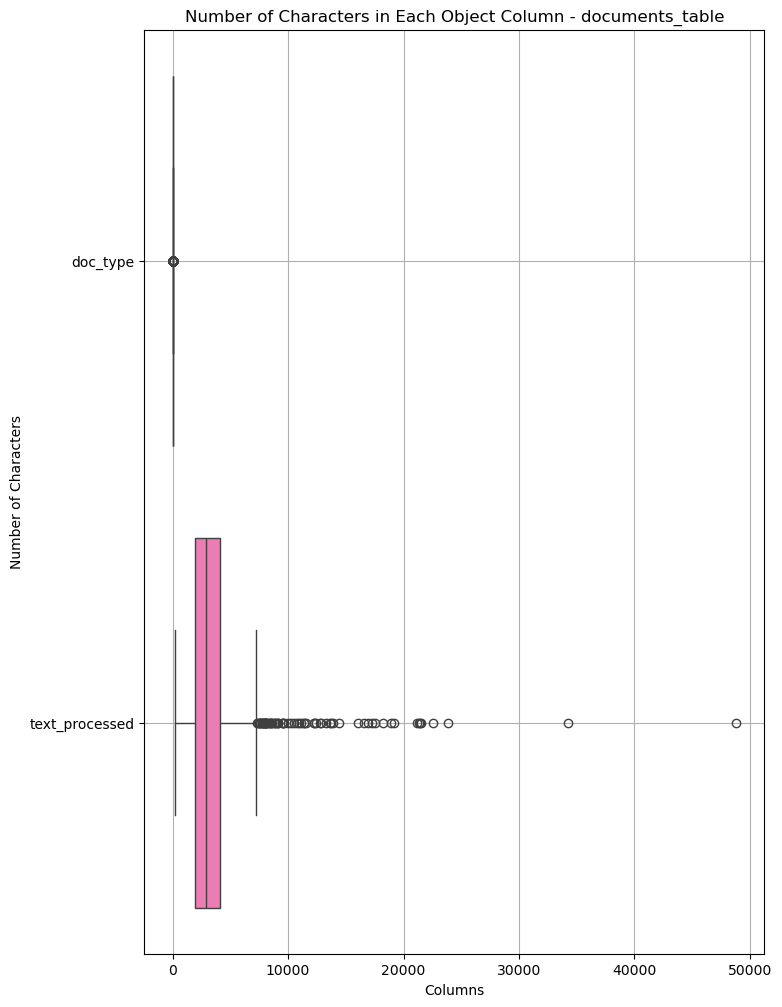


Descriptive Statistics on Character Length:
                 count      mean          std    min      25%     50%     75%  \
doc_type        1000.0     2.366     0.773720    2.0     2.00     2.0     2.0   
text_processed  1000.0  3645.679  3300.544468  229.0  1966.75  2900.0  4086.5   

                    max  
doc_type            4.0  
text_processed  48812.0  


In [18]:
plot_character_length(documents_table, 'documents_table')

### Examine Outlier Text Lengths to Help with VARCHAR Limits

### Rename columns

In [20]:
# Rename some columns
documents_table = documents_table.rename(columns={
    'text_processed': 'doc_text',
    'year': 'doc_year'
})

## PreProcess Events Table

#### Select Columns

In [21]:
events_table = pd.DataFrame(events_df, 
                            columns = ["safetyreportid", #case report number
                                        "transmissiondate", # date the record was created
                                        "serious", # seriousness - 1 = result in death, lifethreatening,hospital,etc. 2 = not in the above
                                        "fulfillexpeditecriteria",  # 1 - Yes, 2 - No
                                        "primarysource.qualification",  # 1-MD, 2-Pharmacist, 3-Health Prof, 4-Lawyer, 5-Consumer/NonHealth
                                        "safetyreportversion",  # Indicates updated reports, with 1 being first, and increasing numbers as new 
                                        "companynumb",  # Company making report
                                        #"seriousnessdeath", # 1 = death, redundant with serious
                                        #  "receivedateformat", #always YYYYMMDD
                                        #  "receivedate", #date report received by FDA
                                        "primarysource.reportercountry", # country of the reporter of this event
                                        "patient.patientonsetage", # age of patient when event occured
                                        "patient.patientonsetageunit",  # 801: Y, 802: M, 803: W, 804: D, 805: H 
                                        "patient.patientsex", # sex of patient. 0=unknown, 1=male, 2=female
                                        "patient.reaction", # Dictionary list - expanded as seperate table
                                        "patient.drug", # Dictionary list - expanded as separate table
                                        # "patient.patientagegroup", #1 = neonate, 2 = infant, 3=child, 4=adolescent, 5=adult, 6=elderly
                                        # "patient.patientweight", # weight in kg
                                        # "seriousnesscongentialanomali", # 1 if congenital anomaly (fetal abnormality),absent otherwise
                                        # "authoritynumb", #regulatory authority case #
                                        # "reportduplicate"
                                      ])

In [29]:
events_table.head(1)

,safetyreportid,transmissiondate,serious,fulfillexpeditecriteria,primarysource.qualification,safetyreportversion,companynumb,primarysource.reportercountry,patient.patientonsetage,patient.patientonsetageunit,patient.patientsex,patient.reaction,patient.drug
0,5801206-7,20090109,1,1,3,NaN,JACAN16471,CANADA,26,801,1,[{'reactionmeddrapt': 'DRUG ADMINISTRATION ERR...,"[{'drugcharacterization': '1', 'medicinalprodu..."


#### Fix Dtypes

In [22]:
events_table['transmissiondate'] = pd.to_datetime(events_table['transmissiondate'], format='%Y%m%d')
events_table['serious'] = events_table['serious'].astype(int)
events_table['fulfillexpeditecriteria'] = events_table['fulfillexpeditecriteria'].astype(int)

events_table['primarysource.qualification'].replace({np.nan: None}, inplace=True)
events_table['primarysource.qualification'] = events_table['primarysource.qualification'].astype(pd.Int64Dtype())

events_table['patient.patientonsetage'].replace({np.nan: None}, inplace=True)
events_table['patient.patientonsetage'] = events_table['patient.patientonsetage'].astype(pd.Int64Dtype())

events_table['patient.patientonsetageunit'].replace({np.nan: None}, inplace=True)
events_table['patient.patientonsetageunit'] = events_table['patient.patientonsetageunit'].astype(pd.Int64Dtype())

events_table['patient.patientsex'].replace({np.nan: None}, inplace=True)
events_table['patient.patientsex'] = events_table['patient.patientsex'].astype(pd.Int64Dtype())

events_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   safetyreportid                 2000 non-null   object        
 1   transmissiondate               2000 non-null   datetime64[ns]
 2   serious                        2000 non-null   int32         
 3   fulfillexpeditecriteria        2000 non-null   int32         
 4   primarysource.qualification    1992 non-null   Int64         
 5   safetyreportversion            1999 non-null   object        
 6   companynumb                    2000 non-null   object        
 7   primarysource.reportercountry  2000 non-null   object        
 8   patient.patientonsetage        1318 non-null   Int64         
 9   patient.patientonsetageunit    1318 non-null   Int64         
 10  patient.patientsex             1988 non-null   Int64         
 11  patient.reaction 

### Standardize Age

In [23]:
events_table['patient.patientonsetage'] = events_table.apply(lambda row: convert_to_years(row['patient.patientonsetage'], row['patient.patientonsetageunit']), axis=1)
events_table.drop(columns=['patient.patientonsetageunit'], inplace=True)
events_table.head(1)

,safetyreportid,transmissiondate,serious,fulfillexpeditecriteria,primarysource.qualification,safetyreportversion,companynumb,primarysource.reportercountry,patient.patientonsetage,patient.patientsex,patient.reaction,patient.drug
0,5801206-7,2009-01-09,1,1,3,NaN,JACAN16471,CANADA,26.0,1,[{'reactionmeddrapt': 'DRUG ADMINISTRATION ERR...,"[{'drugcharacterization': '1', 'medicinalprodu..."


### Feature Engineering

In [24]:
# Serious prior to mapping
events_table['serious'].value_counts()

serious
2    1036
1     964
Name: count, dtype: int64

In [25]:
events_table = add_sequential_index(events_table,'event_id')

# Save 1 as death, life threatening, hospitalization, disability, congenital anomaly, or serious condition, 0 as not that
events_table['serious'] = events_table['serious'].replace({1: 1, 2: 0})

In [26]:
# Serious post-mapping
events_table['serious'].value_counts()

serious
0    1036
1     964
Name: count, dtype: int64

### Check for Report Duplicates

In [27]:
# Check for safety report # duplicates
duplicates = events_table.duplicated(subset=['safetyreportid']).sum()

print("Duplicates: ", duplicates) 

Duplicates:  0


### Examine and Handle Nulls

In [28]:
events_nan = nan_info(events_table)
events_nan

,column_name,null_count,null_proportion
0,event_id,0,0.00
1,safetyreportid,0,0.00
2,transmissiondate,0,0.00
3,serious,0,0.00
4,fulfillexpeditecriteria,0,0.00
5,primarysource.qualification,8,0.40
6,safetyreportversion,1,0.05
7,companynumb,0,0.00
8,primarysource.reportercountry,0,0.00
9,patient.patientonsetage,682,34.10


In [29]:
sex_value_counts = events_table['patient.patientsex'].value_counts()
print(sex_value_counts)

#For sex, 0=unknown, 1=male, 2=female. fill missing values with 0.
events_table['patient.patientsex'] = events_table['patient.patientsex'].fillna(0)

patient.patientsex
2    1184
1     618
0     186
Name: count, dtype: Int64


### Filter Events for Quality Data
* Remove events that have consumer and lawyer reports
* Verify that API called only most recent version of reports

In [30]:
# Drop NaN values in 'primarysource.qualification'
events_table.dropna(subset=['primarysource.qualification'], inplace=True)

# Convert 'primarysource.qualification' to integer
events_table['primarysource.qualification'] = events_table['primarysource.qualification'].astype(int)

# Filter out values 4 and 5
events_table = events_table[~events_table['primarysource.qualification'].isin([4, 5])]

events_table.shape

(757, 13)

In [31]:
# Verified that version control exists in API request
events_table[['safetyreportid', 'safetyreportversion']].head(10)

,safetyreportid,safetyreportversion
0,5801206-7,NaN
4,10003304,2
5,10003305,1
7,10003307,3
8,10003308,3
13,10003313,3
17,10003317,1
18,10003318,2
22,10003322,3
24,10003324,3


### Rename Columns

In [32]:
# Rename some columns
events_table = events_table.rename(columns={
    'primarysource.reportercountry': 'country',
    'patient.patientsex': 'sex',
    'patient.reaction': 'reaction',
    'patient.drug': 'drug',
    'transmissiondate': 'event_date',
    'fulfillexpeditedcriteria': 'expedited',
    'primarysource.qualification': 'report_source',
    'companynumb': 'company'
})

### Examine Variables in Reaction Nested Dataframe - Multiple Reaction Reports for Each Symptom for Each Person

In [33]:
test_record = events_table['reaction'].loc[events_table['event_id'] == 2000]
# Patient Reaction is an array containing:
    # reactionmeddrapt: Patient reaction, as a MedDRA term. 
    # reactionmeddraversionpt: The version of MedDRA from which the term in reactionmeddrapt is drawn.
    # reactionoutcome: Outcome of the reaction in reactionmeddrapt at the time of last observation.
        # 1= Recovered/resolved, 2=recovering/resolving, 3 = Not recovered/not resolved, 4=Recovered/resolved with consequent health issues
        # 5 = fatal, 6 = Unknown

# First, want to individualzie these fields. Will actually save these as a NEW table, called PatientReactions

In [34]:
# Set pandas option to display full content of columns
pd.set_option('display.max_colwidth', None)
print(test_record)

1999    [{'reactionmeddraversionpt': '17.0', 'reactionmeddrapt': 'Tremor', 'reactionoutcome': '3'}, {'reactionmeddraversionpt': '17.0', 'reactionmeddrapt': 'Muscle disorder', 'reactionoutcome': '3'}, {'reactionmeddraversionpt': '17.0', 'reactionmeddrapt': 'Injection site erythema', 'reactionoutcome': '3'}]
Name: reaction, dtype: object


### Make new table for PatientDrugs - nested dataframe

In [45]:
expanded_patient_drugs = []

# Iterate through each row of the original DataFrame
for _, row in events_table.iterrows():
    event_id = row['event_id']
    
    # Iterate through each drug entry in 'patient.drug' list
    for drug_entry in row['drug']:
        # Flatten nested JSON into columns
        flattened_entry = json_normalize(drug_entry)
        
        # Add event_id to the flattened entry
        flattened_entry['event_id'] = event_id
        
        # Append the flattened entry to the list
        expanded_patient_drugs.append(flattened_entry)

# Concatenate all entries into a new DataFrame
patient_drugs_table = pd.concat(expanded_patient_drugs, ignore_index=True)
patient_drugs_table = patient_drugs_table[['event_id'] + [col for col in patient_drugs_table.columns if col != 'event_id']]


patient_drugs_table.tail()

,event_id,drugcharacterization,medicinalproduct,drugauthorizationnumb,drugadministrationroute,drugindication,drugdosagetext,actiondrug,openfda.application_number,openfda.brand_name,...,drugrecurreadministration,drugenddateformat,drugenddate,drugbatchnumb,drugseparatedosagenumb,drugintervaldosageunitnumb,drugintervaldosagedefinition,drugcumulativedosagenumb,drugcumulativedosageunit,drugadditional
2867,1997,1,OXALIPLATIN,NaN,065,COLORECTAL CANCER,NaN,5,"[ANDA207325, ANDA203869, ANDA207474, ANDA204616, ANDA217348, ANDA078803, ANDA204368, ANDA078817, ANDA078813, ANDA091358, NDA021759, NDA022160, ANDA207562, ANDA078811, ANDA205529, ANDA207385]",[OXALIPLATIN],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2868,1998,1,ENDOXAN-1G,012142,065,PLASMA CELL MYELOMA,3 TO 4 G/M2 ON DAY 0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2869,1998,1,GRANULOCYTE COLONY-STIMULATING FACTOR NOS,NaN,065,PLASMA CELL MYELOMA,STARTING ON DAY 5 AND ADMINISTER UNTIL END OF STEM CELL COLLECTION,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,1,804,NaN,NaN,NaN
2870,1998,1,GRANULOCYTE COLONY-STIMULATING FACTOR NOS,NaN,065,NaN,12 HOURS LATER,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2871,2000,1,REBIF,103780,NaN,PRODUCT USED FOR UNKNOWN INDICATION,NaN,4,[BLA103780],[REBIF],...,NaN,NaN,NaN,AU007689,3,1,803,NaN,NaN,NaN


### Make new table for PatientReactions

In [36]:
expanded_patient_reaction = []

# Iterate through each row of the original DataFrame
for _, row in events_table.iterrows():
    event_id = row['event_id']
    
    # Iterate through each drug entry in 'patient.drug' list
    for drug_entry in row['reaction']:
        # Flatten nested JSON into columns
        flattened_entry = json_normalize(drug_entry)
        
        # Add event_id to the flattened entry
        flattened_entry['event_id'] = event_id
        
        # Append the flattened entry to the list
        expanded_patient_reaction.append(flattened_entry)

# Concatenate all entries into a new DataFrame
patient_reactions_table = pd.concat(expanded_patient_reaction, ignore_index=True)
patient_reactions_table = patient_reactions_table[['event_id'] + [col for col in patient_reactions_table.columns if col != 'event_id']]
patient_reactions_table.tail()

,event_id,reactionmeddrapt,reactionmeddraversionpt,reactionoutcome
2208,1997,Disease progression,17.0,6
2209,1998,Hypokalaemia,17.0,6
2210,2000,Tremor,17.0,3
2211,2000,Muscle disorder,17.0,3
2212,2000,Injection site erythema,17.0,3


### Assess Text Field Lengths

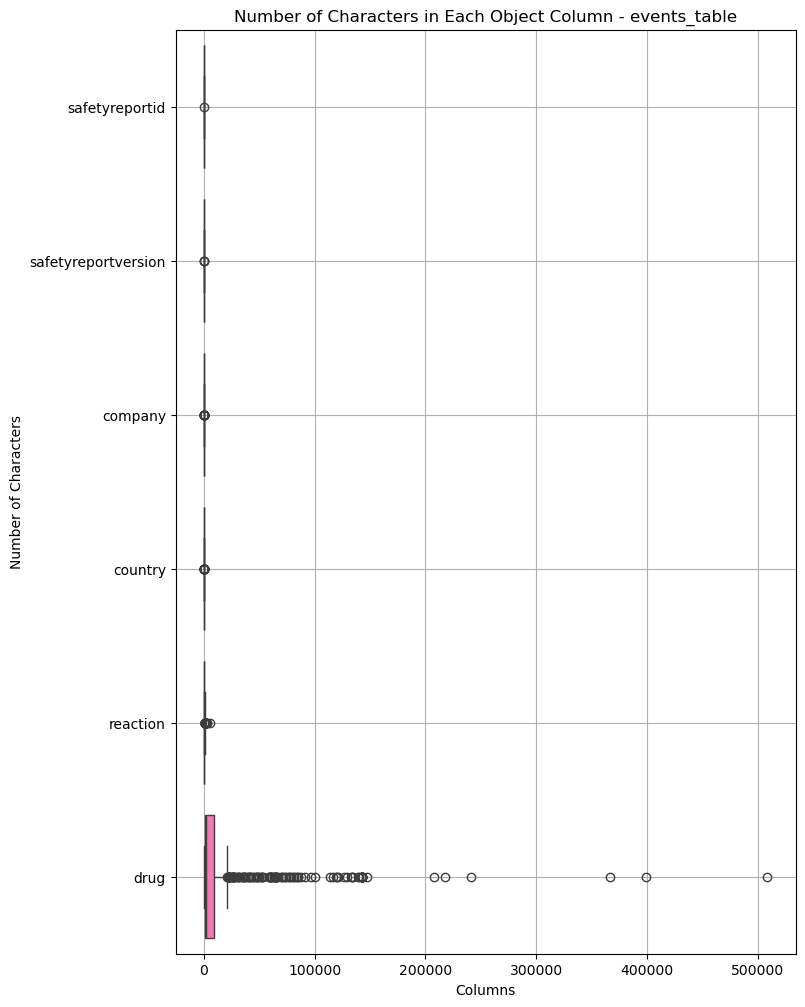


Descriptive Statistics on Character Length:
                     count          mean           std    min     25%     50%  \
safetyreportid       757.0      8.001321      0.036346    8.0     8.0     8.0   
safetyreportversion  757.0      1.005284      0.088930    1.0     1.0     1.0   
company              757.0     25.376486      7.424194   10.0    22.0    24.0   
country              757.0      2.733157      3.651139    2.0     2.0     2.0   
reaction             757.0    291.813738    358.902045   85.0   102.0   195.0   
drug                 757.0  16107.867900  41365.070401  164.0  1255.0  2329.0   

                        75%       max  
safetyreportid          8.0       9.0  
safetyreportversion     1.0       3.0  
company                28.0      55.0  
country                 2.0      21.0  
reaction              328.0    5267.0  
drug                 9032.0  508656.0  


In [37]:
plot_character_length(events_table, 'events_table')

### Examine Outlier Text Lengths to Help with VARCHAR Limits

## PreProcess Patient Drugs Table

In [38]:
patient_drugs_table

patient_drugs_table.head()

patient_drugs_table.columns

Index(['event_id', 'drugcharacterization', 'medicinalproduct',
       'drugauthorizationnumb', 'drugadministrationroute', 'drugindication',
       'drugdosagetext', 'actiondrug', 'openfda.application_number',
       'openfda.brand_name', 'openfda.generic_name',
       'openfda.manufacturer_name', 'openfda.product_ndc',
       'openfda.product_type', 'openfda.route', 'openfda.substance_name',
       'openfda.rxcui', 'openfda.spl_id', 'openfda.spl_set_id',
       'openfda.package_ndc', 'openfda.unii', 'openfda.nui',
       'openfda.pharm_class_epc', 'openfda.pharm_class_cs', 'drugdosageform',
       'openfda.pharm_class_moa', 'openfda.pharm_class_pe',
       'drugstructuredosagenumb', 'drugstructuredosageunit',
       'drugstartdateformat', 'drugstartdate',
       'activesubstance.activesubstancename', 'drugrecurreadministration',
       'drugenddateformat', 'drugenddate', 'drugbatchnumb',
       'drugseparatedosagenumb', 'drugintervaldosageunitnumb',
       'drugintervaldosagedefinition

#### Select Columns

In [46]:
patient_drugs_table = pd.DataFrame(patient_drugs_table, 
                               columns = [
                                'event_id',  # Identifier for the event
                                'drugcharacterization',  # Level of detail for the drug in the event report
                                'medicinalproduct',  # Name of the drug
                                # 'drugauthorizationnumb',  # Marketing authorization number of the drug
                                # 'drugadministrationroute',  # Route of administration for the drug
                                'drugindication',  # Indication for use of the drug
                                # 'drugbatchnumb',  # Batch number for the drug
                                # 'drugstructuredosagenumb',  # Structured dosage number of the drug
                                # 'drugstructuredosageunit',  # Unit of structured dosage for the drug
                                # 'drugdosagetext',  # Textual description of the dosage for the drug
                                # 'drugstartdateformat',  # Date format for the start date of drug administration
                                # 'drugstartdate',  # Start date of drug administration
                                #'drugrecurreadministration',  # Indicator for recurring drug administration
                                # 'drugadditional',  # Additional details about the drug
                                # 'openfda.application_number',  # FDA application number for the drug
                                # 'openfda.brand_name',  # Brand name for the drug
                                'openfda.generic_name',  # Generic name for the drug
                                'openfda.manufacturer_name',  # Manufacturer name for the drug
                                #'openfda.product_ndc',  # NDC (National Drug Code) number for the drug product
                                'openfda.product_type',  # Type of drug product (e.g., HUMAN PRESCRIPTION DRUG)
                                # 'openfda.route',  # Route of administration for the drug
                                # 'openfda.substance_name',  # Substance name associated with the drug
                                'openfda.rxcui',  # RxNorm Concept Unique Identifier (RxCUI) for the drug
                                # 'openfda.spl_id',  # Structured Product Labeling (SPL) ID for the drug
                                # 'openfda.spl_set_id',  # SPL Set ID for the drug
                                # 'openfda.package_ndc',  # NDC (National Drug Code) number for the drug package
                                # 'openfda.nui',  # NUI (National Uniform Identifier) for the drug
                                # 'openfda.pharm_class_moa',  # Pharmacological class (Mechanism of Action) for the drug
                                # 'openfda.pharm_class_cs',  # Chemical structure class for the drug
                                # 'openfda.pharm_class_epc',  # Pharmacological class (EPC) for the drug
                                'openfda.unii',  # Unique Ingredient Identifier (UNII) for the drug substance
                                # 'actiondrug',  # Action taken with the drug
                                # 'drugdosageform',  # Dosage form of the drug
                                # 'openfda.pharm_class_pe',  # Pharmacological class (Physiologic Effect) for the drug
                                # 'activesubstance.activesubstancename',  # Name of the active substance in the drug
                                # 'drugenddateformat',  # Date format for the end date of drug administration
                                # 'drugenddate',  # End date of drug administration
                                #'drugseparatedosagenumb',  # Separated dosage number for the drug
                                # 'drugintervaldosageunitnumb',  # Interval dosage unit number for the drug
                                # 'drugintervaldosagedefinition',  # Definition of interval dosage for the drug
                                # 'drugcumulativedosagenumb',  # Cumulative dosage number for the drug
                                # 'drugcumulativedosageunit'  # Unit of cumulative dosage for the drug
                            ])


#### Fix Dtypes

In [47]:
patient_drugs_table['drugcharacterization'] = patient_drugs_table['drugcharacterization'].astype(int)

#### Filter for Quality Data

In [48]:
# Add unique ID
patient_drugs_table = add_sequential_index(patient_drugs_table,'patient_drug_id')

# Keep only primary drug suspects
patient_drugs_table = patient_drugs_table.loc[patient_drugs_table['drugcharacterization'] == 1]

#### Examining Variables of Interest
* Drugcharacterization: 1-suspect(drug primary cause), 2-concomitant(drug taken with primary cause), 3-interation(drug interact with primary cause)
* Medicinalproduct: generic or brand name
* Drugindication: official drug purpose
* openfda.rxcui : Rx cui code
* openfda.unii : unique ingredient identifier

In [49]:
patient_drugs_table['drugcharacterization'].value_counts()

drugcharacterization
1    1494
Name: count, dtype: int64

In [50]:
patient_drugs_table_nan_info = nan_info(patient_drugs_table)
patient_drugs_table_nan_info

,column_name,null_count,null_proportion
0,patient_drug_id,0,0.000000
1,event_id,0,0.000000
2,drugcharacterization,0,0.000000
3,medicinalproduct,0,0.000000
4,drugindication,417,27.911647
5,openfda.generic_name,401,26.840696
6,openfda.manufacturer_name,401,26.840696
7,openfda.product_type,401,26.840696
8,openfda.rxcui,416,27.844712
9,openfda.unii,439,29.384203


### Text Processing

In [51]:
# Define text columns
object_columns = patient_drugs_table.select_dtypes(include=['object']).columns

# Exclude columns that should not be tokenized, index codes
object_columns = object_columns.drop(['openfda.unii', 'openfda.rxcui'], errors='ignore')
patient_drugs_table[object_columns] = patient_drugs_table[object_columns].astype(str)

# Apply text processing to the selected text columns and add new processed columns to dataframe
for col in object_columns:
    new_col_name = col + '_processed'
    patient_drugs_table[new_col_name] = patient_drugs_table[col].apply(process_label_text)

### Final list of features for Patient Drugs Table

In [52]:
patient_drugs_table = patient_drugs_table[['patient_drug_id',
                                          'event_id',
                                          #'drugcharacterization',  # Not necessary since table is filtered to value of 1 for all
                                           'drugindication_processed',
                                          'medicinalproduct_processed',
                                          'openfda.generic_name_processed',
                                          'openfda.manufacturer_name_processed',
                                          'openfda.product_type_processed',
                                          'openfda.rxcui',
                                          'openfda.unii'
                                          ]]

### Rename Columns

In [53]:
patient_drugs_table = patient_drugs_table.rename(columns={
    'medicinalproduct_processed': 'med_product',
    'drugindication_processed': 'indication',
    'openfda.generic_name_processed': 'generic_name',
    'openfda.manufacturer_name_processed': 'manufacturer',
    'openfda.product_type_processed': 'product_type',
    'openfda.rxcui': 'rxcui',
    'openfda.unii': 'unii'
})

In [54]:
patient_drugs_table.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1494 entries, 0 to 2871
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   patient_drug_id  1494 non-null   int64 
 1   event_id         1494 non-null   int64 
 2   indication       1077 non-null   object
 3   med_product      1494 non-null   object
 4   generic_name     1093 non-null   object
 5   manufacturer     1093 non-null   object
 6   product_type     1093 non-null   object
 7   rxcui            1078 non-null   object
 8   unii             1055 non-null   object
dtypes: int64(2), object(7)
memory usage: 116.7+ KB


### Assess Text Field Lengths

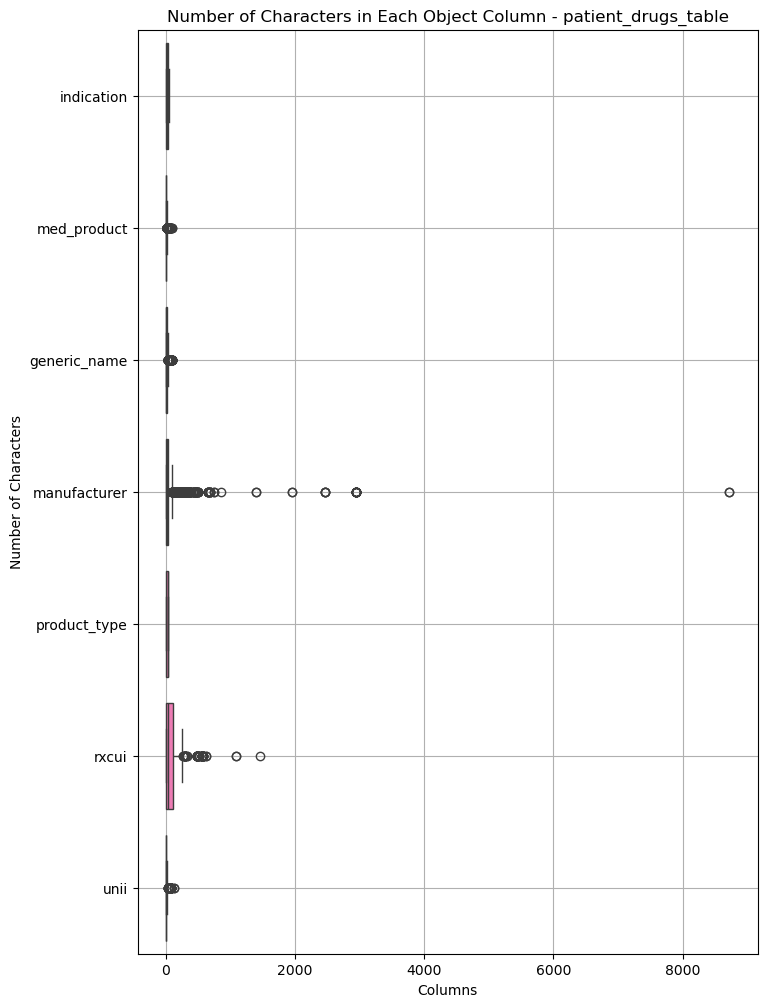


Descriptive Statistics on Character Length:
               count        mean         std  min   25%   50%     75%     max
indication    1494.0   21.937751   14.649539  4.0   4.0  21.0   33.00    56.0
med_product   1494.0   14.979920    9.008049  7.0  11.0  12.0   15.00    96.0
generic_name  1494.0   15.969210   13.819489  4.0   4.0  15.0   16.00   103.0
manufacturer  1494.0  111.629183  464.547993  4.0   4.0  27.0   41.75  8721.0
product_type  1494.0   25.364123   13.028022  4.0   4.0  33.0   33.00    40.0
rxcui         1494.0   80.630522  121.363983  3.0   3.0  40.0  110.00  1461.0
unii          1494.0   12.388889   10.676170  3.0   3.0  14.0   14.00   126.0


In [55]:
plot_character_length(patient_drugs_table, 'patient_drugs_table')

### Examine Outlier Text Lengths to Help with VARCHAR Limits

## PreProcess Patient Reactions Table

### Rename Columns

In [56]:
patient_reactions_table = patient_reactions_table.rename(columns={
    'reactionmeddrapt': 'reaction',
    'reactionmeddraversionpt': 'version_medDRA',
    'reactionoutcome': 'outcome'
})

### Fix Dtypes

In [57]:
#n/a
#patient_reactions_table.head(10)
#patient_reactions_table.info()

### Feature Engineering

In [58]:
patient_reactions_table = add_sequential_index(patient_reactions_table,'patient_reaction_id')

### Map Features

In [59]:
#map outcomes to text categories

outcome_mapping = {
    1: 'Recovered/resolved',
    2: 'Recovering/resolving',
    3: 'Not recovered/not resolved',
    4: 'Recovered/resolved with consequent health issues',
    5: 'Fatal',
    6: 'Unknown'
}

# if outcome is 'Unknown', change to 6 (which will map to unknown again). Necessary that this column is int for mapping
patient_reactions_table.loc[patient_reactions_table['outcome'] == 'Unknown', 'outcome'] = 6

# Perform mapping by outcome mapping
patient_reactions_table['outcome'] = patient_reactions_table['outcome'].fillna(0).astype(int).map(outcome_mapping)

patient_reactions_table.tail()

,patient_reaction_id,event_id,reaction,version_medDRA,outcome
2208,2209,1997,Disease progression,17.0,Unknown
2209,2210,1998,Hypokalaemia,17.0,Unknown
2210,2211,2000,Tremor,17.0,Not recovered/not resolved
2211,2212,2000,Muscle disorder,17.0,Not recovered/not resolved
2212,2213,2000,Injection site erythema,17.0,Not recovered/not resolved


### Text Processing

In [60]:
patient_reactions_table['reaction_processed'] = patient_reactions_table['reaction'].apply(process_label_text)
patient_reactions_table = patient_reactions_table.drop('reaction', axis = 1)

### Examine Nulls

In [61]:
patient_reactions_table_nan_info = nan_info(patient_reactions_table)
patient_reactions_table_nan_info

#fill the missing values in the outcome table with 'Unknown'
patient_reactions_table['outcome'] = patient_reactions_table['outcome'].fillna('Unknown')

patient_reactions_table_nan_info = nan_info(patient_reactions_table)
patient_reactions_table_nan_info


,column_name,null_count,null_proportion
0,patient_reaction_id,0,0.000000
1,event_id,0,0.000000
2,version_medDRA,2,0.090375
3,outcome,0,0.000000
4,reaction_processed,0,0.000000


### Filter for Data Quality

In [62]:
# Drop cases with "unknown" outcomes
patient_reactions_table = patient_reactions_table.loc[patient_reactions_table['outcome'] != 'Unknown']

### Assess Text Field Lengths

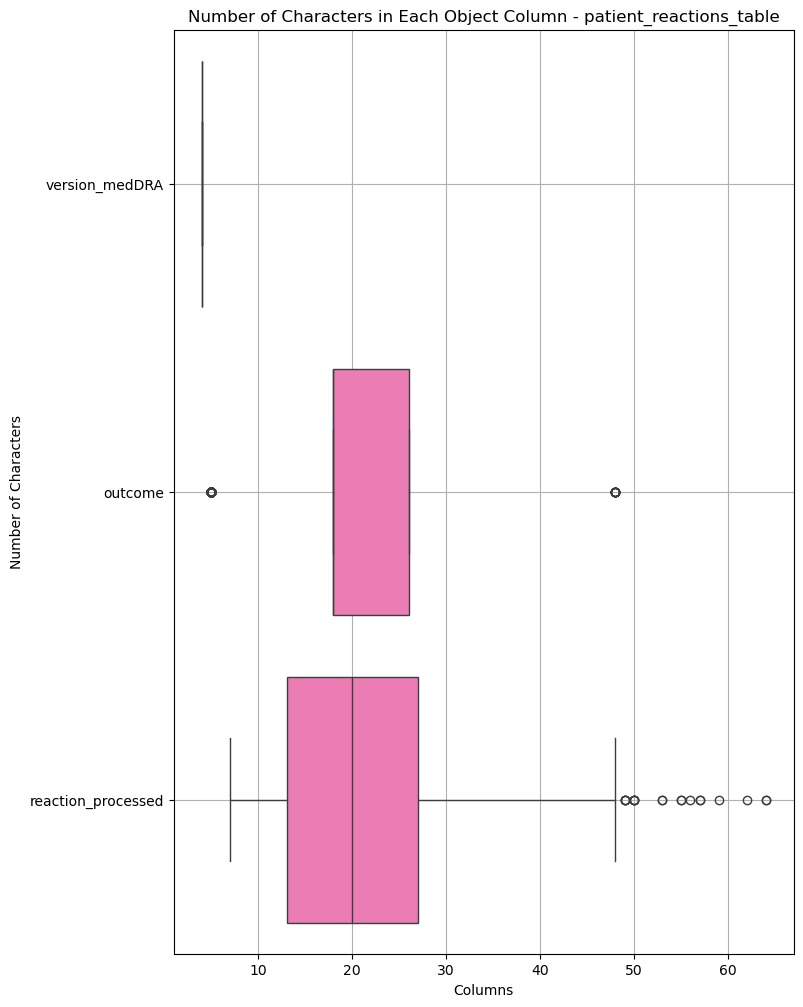


Descriptive Statistics on Character Length:
                     count       mean        std  min   25%   50%   75%   max
version_medDRA      1018.0   4.000000   0.000000  4.0   4.0   4.0   4.0   4.0
outcome             1018.0  19.429273   6.541856  5.0  18.0  18.0  26.0  48.0
reaction_processed  1018.0  21.400786  10.299282  7.0  13.0  20.0  27.0  64.0


In [63]:
plot_character_length(patient_reactions_table, 'patient_reactions_table')

### Examine Outlier Text Lengths to Help with VARCHAR Limits

## PreProcess Labels Table

#### Select Columns

In [76]:
labels_table = pd.DataFrame(labels_df, 
                            columns = ["effective_time",
                                       #"inactive_ingredient",  # Included in spl_product_data_elements
                                       "purpose",
                                       "warnings",  # Combine text with contraindications and precautions
                                        #"questions",  # Too much missing data
                                       "spl_product_data_elements",  # Contains both active and inactive ingredients
                                        #"version",  # Label version, not needed since ndc code captures this information
                                        #"package_label_principal_display_panel",  # Package label text, redundant information
                                        #"active_ingredient",  # Included in spl_product_data_elements
                                        "openfda.brand_name",  # Combine into list with generic
                                        "openfda.generic_name",  # Combine into list with brand
                                        "openfda.manufacturer_name",  # Company that produces the drug
                                        #"openfda.product_type",  # Denotes whether OTC and prescription, and human or animal, redundant with events
                                        "openfda.substance_name",  # Combine with brand and generic
                                        "openfda.product_ndc",  # Do NOT tokenize, NDC Product code, use as database key, already a list
                                        #"openfda.package_ndc",  # Product NDC code plus one extra number for package type, Redundant
                                        "openfda.rxcui",  # Do NOT tokenize, normed drug code number, retain for database keys
                                        "contraindications",  # Combine with warnings and precautions
                                        "precautions"  # Combine with warnings and contraindications
                                        ])

In [77]:
labels_table['purpose'].head()

0    [USES USES: Temporary Relief - Acne, Boils* * Claims based on traditional homeopathic practice, not accepted medical evidence. Not FDA evaluated.]
1                                                                                                                                   [Purpose Sunscreen]
2                                                                                                            [USES To relieve the symptoms of itching.]
3                                                                                                                                                   NaN
4                                                                                                                                                   NaN
Name: purpose, dtype: object

### Examine Nulls

In [78]:
labels_nan = nan_info(labels_table)
labels_nan

,column_name,null_count,null_proportion
0,effective_time,0,0.00
1,purpose,809,40.45
2,warnings,414,20.70
3,spl_product_data_elements,1,0.05
4,openfda.brand_name,1016,50.80
5,openfda.generic_name,1016,50.80
6,openfda.manufacturer_name,1016,50.80
7,openfda.substance_name,1026,51.30
8,openfda.product_ndc,1016,50.80
9,openfda.rxcui,1265,63.25


### Fix Dtypes

In [79]:
labels_table['effective_time'] = pd.to_datetime(labels_table['effective_time'], format='%Y%m%d')

### Process Text Columns

In [80]:
# Define text columns
object_columns = labels_table.select_dtypes(include=['object']).columns

# Exclude columns that should not be tokenized, index codes
object_columns = object_columns.drop(['label_id', 'openfda.product_ndc', 'openfda.rxcui'], errors='ignore')
labels_table[object_columns] = labels_table[object_columns].astype(str)

# Apply text processing to the selected text columns and add new processed columns to dataframe
for col in object_columns:
    new_col_name = col + '_processed'
    labels_table[new_col_name] = labels_table[col].apply(process_label_text)

### Examine all variables for quality, content, and redundancy

In [81]:
#labels_table['spl_product_data_elements_processed'].head(5)

In [82]:
#labels_table['purpose'].head()

In [83]:
#labels_table['purpose_processed'].info()

In [84]:
#labels_table['purpose_processed'].head(5)

In [85]:
#labels_table['warnings'].head()

In [86]:
#labels_table['warnings_processed'].head()

In [87]:
#labels_table['contraindications'].head()

In [88]:
#labels_table['contraindications_processed'].head()

In [89]:
#labels_table['precautions'].head()

In [90]:
#labels_table['precautions_processed'].head()

In [ ]:
#labels_table['openfda.brand_name_processed'].head()

In [ ]:
#labels_table['openfda.generic_name_processed'].head()

In [ ]:
#labels_table['openfda.manufacturer_name_processed'].head()

In [ ]:
#labels_table['openfda.product_type_processed'].head()

In [ ]:
#labels_table['openfda.substance_name_processed'].head()

In [ ]:
#labels_table['openfda.product_ndc'].head()

### Feature Creation for Labels Data

In [91]:
# Add index column
labels_table = add_sequential_index(labels_table,'label_id')

# Combine warnings, contraindications, and precautions text
labels_table['all_warnings_processed'] = labels_table['warnings_processed'] + labels_table['contraindications_processed'] + labels_table['precautions_processed']
# Remove duplicate tokens from combination list
labels_table['all_warnings_processed'] = labels_table['all_warnings_processed'].apply(remove_duplicates_nan)
 
# Combine brand name, generic name, and substance name
labels_table['all_name_processed'] = labels_table['openfda.brand_name_processed'] + labels_table['openfda.generic_name_processed'] + labels_table['openfda.substance_name_processed']
# Remove duplicate tokens to retain unique descriptors only
labels_table['all_name_processed'] = labels_table['all_name_processed'].apply(remove_duplicates_nan)


### Final List of Features for Labels Data

In [92]:
labels_table.columns

Index(['label_id', 'effective_time', 'purpose', 'warnings',
       'spl_product_data_elements', 'openfda.brand_name',
       'openfda.generic_name', 'openfda.manufacturer_name',
       'openfda.substance_name', 'openfda.product_ndc', 'openfda.rxcui',
       'contraindications', 'precautions', 'purpose_processed',
       'warnings_processed', 'spl_product_data_elements_processed',
       'openfda.brand_name_processed', 'openfda.generic_name_processed',
       'openfda.manufacturer_name_processed',
       'openfda.substance_name_processed', 'contraindications_processed',
       'precautions_processed', 'all_warnings_processed',
       'all_name_processed'],
      dtype='object')

In [93]:
labels_table = labels_table[['label_id', 
                             'openfda.product_ndc',
                             'openfda.rxcui',
                             'effective_time',
                            'spl_product_data_elements_processed', 
                             'all_warnings_processed', 
                             'all_name_processed', 
                            'purpose_processed']]

In [94]:
labels_table.head(2)

,label_id,openfda.product_ndc,openfda.rxcui,effective_time,spl_product_data_elements_processed,all_warnings_processed,all_name_processed,purpose_processed
0,1,[15631-0404],NaN,2021-09-02,"[silicea, sucrose, silicon, dioxide]",NaN,"[silicon, silicea, dioxide]","[us, temporary, relief, acne, boil, claim, based, traditional, homeopathic, practice, accepted, medical, evidence, fda, evaluated]"
1,2,NaN,NaN,2015-01-09,"[chantecaille, protection, naturelle, bronze, spf, 46, titanium, dioxide, octinoxate, zinc, oxide, talc, calcium, silicate, triethylhexanoin, aluminum, hydroxide, lauroyl, lysine, phenoxyethanol, dimethicone, dimyristate, mica, ferric, red]",NaN,NaN,"[purpose, sunscreen]"


### Assess Text Field Lengths

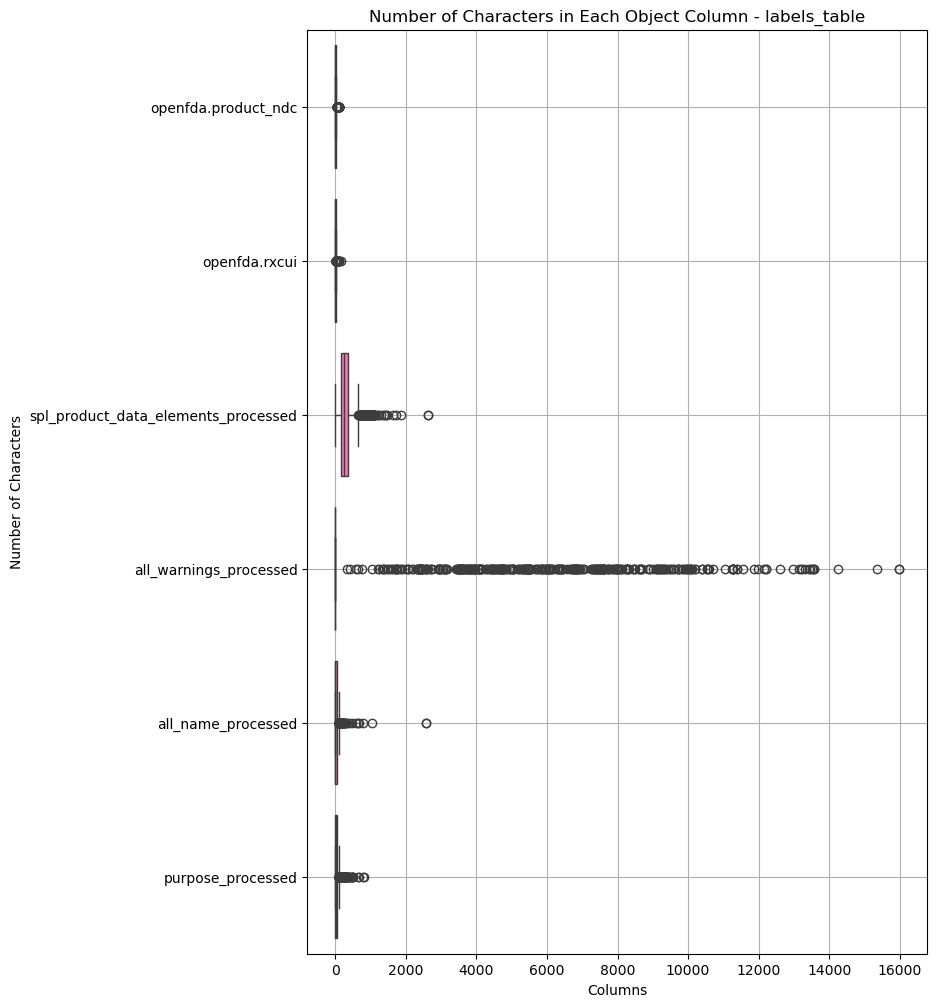


Descriptive Statistics on Character Length:
                                      count       mean          std  min  \
openfda.product_ndc                  2000.0    10.2290    13.140049  3.0   
openfda.rxcui                        2000.0     7.2700     9.236057  3.0   
spl_product_data_elements_processed  2000.0   294.7915   221.713108  4.0   
all_warnings_processed               2000.0  1184.5120  2792.339720  3.0   
all_name_processed                   2000.0    33.8770    98.308195  3.0   
purpose_processed                    2000.0    37.1260    62.294377  4.0   

                                       25%    50%    75%      max  
openfda.product_ndc                    3.0    3.0   13.0    112.0  
openfda.rxcui                          3.0    3.0   10.0    153.0  
spl_product_data_elements_processed  160.0  254.0  357.0   2636.0  
all_warnings_processed                 3.0    3.0    3.0  15981.0  
all_name_processed                     3.0    3.0   43.0   2581.0  
purpose_proces

In [95]:
plot_character_length(labels_table, 'labels_table')

### Examine Outlier Text Lengths to Help with VARCHAR Limits

### Rename Columns

In [96]:
labels_table = labels_table.rename(columns = {'openfda.product_ndc': 'ndc',
                                              'openfda.rxcui': 'rxcui',
                         'effective_time': 'label_date',
                         'spl_product_data_elements_processed': 'ingredients',
                         'all_warnings_processed': 'warnings',
                         'all_name_processed': 'drug_names',
                         'openfda.manufacturer_name_processed': 'manufacturer',
                         'purpose_processed': 'purpose'})

In [97]:
labels_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   label_id     2000 non-null   int64         
 1   ndc          984 non-null    object        
 2   rxcui        735 non-null    object        
 3   label_date   2000 non-null   datetime64[ns]
 4   ingredients  1999 non-null   object        
 5   warnings     382 non-null    object        
 6   drug_names   974 non-null    object        
 7   purpose      1168 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 125.1+ KB


## PreProcess Prices Table

### Select Columns

In [98]:
prices_table = pd.DataFrame(prices_df, 
                            columns = [#"NDC Description",  # Identifies the drug name/dosage, Redundant Information with labels_table
                                       "NDC",  # 11 character FDA code, Do NOT Tokenize, database key
                                       "NADAC_Per_Unit",  #  The National Average Drug Acquisition Cost per unit, do NOT tokenize
                                       "Effective Date",  # The effective date of the NADAC Per Unit cost
                                        #"Pricing_Unit",  # Pricing unit for NDC ('ML', 'GM 'or 'EA'), Not necessary, just use price
                                        #"Pharmacy_Type_Indicator",  # 'C/I' data from Chain/Independent pharmacies, does not provide helpful info
                                        #"OTC",  # Indicates whether NDC is over-the-counter (OTC), redundant with labels_table
                                        #"Explanation Code",  # NADAC Calculation Method, not necessary for this project, too much missing data
                                                                       # Code 1: Inform from most recent survey.
                                                                       # Code 2: Cost within ± 2%, carried forward from previous
                                                                       # Code 3: Published pricing, or help desk inquiry
                                                                       # Code 4: Carried forward from previous year
                                                                       # Code 5: Based on package size.
                                                                       # Code 6: CMS Covered Outpatient Drug Product File drug category 
                                        "Classification_for_Rate_Setting",  # B: brand, 
                                                                            # G: generic
                                                                            # B-ANDA: brand under ANDA
                                                                            # B-BIO: biosimilar brand  
                                        "Corresponding_Generic_Drug_NADAC_Per_Unit",
                                        "Corresponding_Generic_Drug_Effective_Date"
                                        #"As of Date"
                                      ])

#prices_table = prices_table[['NDC', 'NADAC_Per_Unit', 'Effective Date', 'Classification_for_Rate_Setting', 
#                             'Corresponding_Generic_Drug_NADAC_Per_Unit', 'Corresponding_Generic_Drug_Effective_Date']]


### Fix Dtypes

In [99]:
prices_table['Effective Date'] = pd.to_datetime(prices_table['Effective Date'])
#prices_table['Corresponding_Generic_Drug_Effective_Date'] = pd.to_datetime(prices_table['Corresponding_Generic_Drug_Effective_Date'])
prices_table['NADAC_Per_Unit'] = prices_table['NADAC_Per_Unit'].astype(float)

### Examine Nulls

In [101]:
# replace empty strings with nan
prices_table = prices_table.replace(r'^\s*$', np.nan, regex=True)

prices_nan = nan_info(prices_table)
prices_nan

,column_name,null_count,null_proportion
0,NDC,0,0.0
1,NADAC_Per_Unit,0,0.0
2,Effective Date,0,0.0
3,Classification_for_Rate_Setting,0,0.0
4,Corresponding_Generic_Drug_NADAC_Per_Unit,971,97.1
5,Corresponding_Generic_Drug_Effective_Date,971,97.1


### Feature Engineering 

In [102]:
prices_table['Classification_for_Rate_Setting'].value_counts()

Classification_for_Rate_Setting
G         932
B          62
B-ANDA      6
Name: count, dtype: int64

In [103]:
# Update classification to binary generic/brand, G:1 B:0
prices_table['Classification_for_Rate_Setting'] = prices_table['Classification_for_Rate_Setting'].apply(lambda x: 1 if x == 'G' else 0)

In [104]:
# Add index column
prices_table = add_sequential_index(prices_table, 'price_id')

### Rename Columns

In [106]:
prices_table = prices_table.rename(columns = {'NDC': 'ndc',
                         'NADAC_Per_Unit': 'unit_price',
                         'Effective Date': 'price_date',
                         'Classification_for_Rate_Setting': 'generic_brand',
                         'Corresponding_Generic_Drug_NADAC_Per_Unit': 'generic_price',
                         'Corresponding_Generic_Drug_Effective_Date': 'generic_date'})

In [107]:
prices_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   price_id       1000 non-null   int64         
 1   ndc            1000 non-null   object        
 2   unit_price     1000 non-null   float64       
 3   price_date     1000 non-null   datetime64[ns]
 4   generic_brand  1000 non-null   int64         
 5   generic_price  29 non-null     object        
 6   generic_date   29 non-null     object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 54.8+ KB


# Standardization and Normalization

## Read in ADReCS Files

In [110]:
adrecs_drugs = pd.read_excel('ADReCS/Drug_information_v3.3.xlsx')
adrecs_drugs.head()

,DRUG_ID,DRUG_NAME,DRUG_SYNONYMS,DrugBank_ID,PubChem_ID,MESH_ID,KEGG_ID,TTD_ID
0,BADD_D00001,"1,2-hexanediol","1,2-hexanediol",DB14108,94335,C119102,Not Available,Not Available
1,BADD_D00002,2-hydroxy-3-phenylpropanoic acid,"3-phenyllactic acid | 3-phenyllactic acid, monosodium salt | beta-phenyllactic acid | 3-phenyllactic acid, (L)-isomer | phenyllactic acid | 3-phenyllactate | 3-phenyllactic acid, (D)-isomer | 3-phenyllactic acid, calcium salt | 3-phenyllactic acid, (DL)-isomer",Not Available,3848,C017648,Not Available,Not Available
2,BADD_D00003,2-phenylbutyric acid,2-phenylbutyric acid | 2-phenylbutanoic acid,Not Available,7012,C039714,Not Available,Not Available
3,BADD_D00004,2-[1-methyl-5-(4-methylbenzoyl)pyrrol-2-yl]acetate,"Tolmetin | Tolectin | Tolmetin Sodium, Anhydrous | Anhydrous Tolmetin Sodium | Tolmetin Sodium Anhydrous | Anhydrous, Tolmetin Sodium | Sodium Anhydrous, Tolmetin | McN-2559 | McN 2559 | McN2559 | Tolmetin Sodium | Sodium, Tolmetin | Tolmetin Sodium, Dihydrate | Dihydrate Tolmetin Sodium",DB00500,5508,D014046,D00158; D02355,D09BHB
4,BADD_D00005,4-oxo-3-(3-oxo-1-phenylbutyl)chromen-2-olate,"Warfarin | 4-Hydroxy-3-(3-oxo-1-phenylbutyl)-2H-1-benzopyran-2-one | Apo-Warfarin | Aldocumar | Gen-Warfarin | Warfant | Coumadin | Marevan | Warfarin Potassium | Potassium, Warfarin | Warfarin Sodium | Sodium, Warfarin | Coumadine | Tedicumar",DB00682,23690541,D014859,D00564; D08682; D01280,D0E3OF


In [111]:
adrecs_ont = pd.read_excel('ADReCS/ADR_ontology_v3.3.xlsx')
adrecs_ont.head()

,ADRECS_ID,ADR_ID,ADR_TERM,ADR_SYNONYMS,MEDDRA_CODE
0,01,BADD_A00503,Blood and lymphatic system disorders,Not Available,10005329
1,01.01,BADD_A06244,Coagulopathies and bleeding diatheses (excl thrombocytopenic),Not Available,10064477
2,01.01.01,BADD_A00960,Coagulation factor deficiencies,Not Available,10009737
3,01.01.01.001,BADD_A02211,Hypoprothrombinaemia,"Exaggerated hypoprothrombinaemia | Hypoprothrombinaemia | Hypoprothrombinemia | Exaggerated hypoprothrombinemia | Prothrombinopenia | Prothrombinopaenia | Hypoprothrombinemias | Prothrombin Deficiency | Deficiencies, Prothrombin | Deficiency, Prothrombin | Prothrombin Deficiencies | Deficiency, Factor II | Deficiencies, Factor II | Factor II Deficiencies | Factor II Deficiency",10021085
4,01.01.01.002,BADD_A05294,Acquired haemophilia,"Acquired haemophilia | Acquired hemophilia | Acquired hemophilia with anti FVIII, XI, or XIII | Acquired haemophilia with anti FVIII, XI, or XIII | Acquired haemophilia B with anti factor IX | Acquired haemophilia A with anti factor VIII | Acquired hemophilia B with anti factor IX | Acquired hemophilia A with anti factor VIII",10053745


### Clean Text into Tokens with Bigrams

### Create Mapping Dictionaries

## Standardize Drug Names into Primary Ingredient Compounds

## Standardize Adverse Event Terms

# Combining Data into SQL Database Based on Keys

## Create new database to store data

In [ ]:
# connect to MySQL server
connection = mysql.connector.connect(host="localhost", user="root", password=PASSWORD)

# Create a cursor object
cursor = connection.cursor()

# Drop the database if it exists - this is so we can start fresh (at least while developing)
cursor.execute("DROP DATABASE IF EXISTS pharma_db")

# Create the 'covid_db' database
cursor.execute("CREATE DATABASE pharma_db")

# Switch to the 'covid_db' database
cursor.execute("USE pharma_db")

# Commit the changes
connection.commit()

# Close the cursor and connection
cursor.close()
connection.close()

### Create Read-Only User Access for Public

In [ ]:
# public username and password

### Create Edit Privelages for Us

In [ ]:
# private username and password

## Create dataframes from API request dataframes

In [ ]:
# Connect to the MySQL server
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

# Create a cursor object
cursor = connection.cursor()

# Create documents table
create_documents_table_query = """
CREATE TABLE IF NOT EXISTS `documents` (
  `doc_id` INT NOT NULL,
  `doc_type` VARCHAR(4),
  `doc_year` INT(4),
  `doc_text` VARCHAR(50000),
  PRIMARY KEY(`doc_id`)
) ENGINE=InnoDB;
"""
cursor.execute(create_documents_table_query)

# Create adverse events table
create_events_query = """
CREATE TABLE IF NOT EXISTS `adverse_events` (
  `event_id` INT NOT NULL,
  `safetyreportid` VARCHAR(9),
  `event_date` DATE,
  `serious` BOOLEAN,
  `expedited` BOOLEAN,
  `report_source` INT,
  `company` VARCHAR(60),
  `country` VARCHAR(25),
  `sex` INT,
  PRIMARY KEY (`event_id`)
) ENGINE=InnoDB;
"""
cursor.execute(create_events_query)

# Create patient_reactions table
create_patient_reactions_query = """
CREATE TABLE IF NOT EXISTS `patient_reactions` (
 `patient_reaction_id` INT NOT NULL,
  `event_id` INT,
  `reaction_processed` VARCHAR(100),
  `version_medRNA` VARCHAR(4),
  `outcome` VARCHAR(50),
  PRIMARY KEY(`patient_reaction_id`),
  FOREIGN KEY (`event_id`) REFERENCES `adverse_events` (`event_id`)
  ON DELETE CASCADE,
  INDEX(`event_id`)
  ) ENGINE=InnoDB;
"""
cursor.execute(create_patient_reactions_query)

# Create labels table
create_labels_query = """
CREATE TABLE IF NOT EXISTS `labels` (
  `label_id` INT NOT NULL AUTO_INCREMENT,
  `rxcui` VARCHAR(1500),
  `ndc` VARCHAR(120), 
  `label_date` DATE,
  `ingredients` VARCHAR(3000),
  `warnings` VARCHAR(16000),
  `manufacturer` VARCHAR(9000),
  `drug_names` VARCHAR(2600),
  `purpose` VARCHAR(900),
  PRIMARY KEY(`label_id`),
  INDEX(`ndc`),
  INDEX(`rxcui`)
) ENGINE=InnoDB;
"""
cursor.execute(create_labels_query)

# Create patient_drugs table
create_patient_drugs_query = """
CREATE TABLE IF NOT EXISTS `patient_drugs` (
 `patient_drug_id` INT NOT NULL AUTO_INCREMENT,
  `event_id` INT,
  `med_product` VARCHAR(100),
  `indication` VARCHAR(60),
  `generic_name` VARCHAR(110),
  `manufacturer` VARCHAR(9000),
  `product_type` VARCHAR(50),
  `rxcui` VARCHAR(1500),
  `unii` VARCHAR(130),
  PRIMARY KEY(`patient_drug_id`),
  FOREIGN KEY (`event_id`) REFERENCES `adverse_events` (`event_id`)
    ON DELETE CASCADE,
  INDEX(`event_id`),
  INDEX(`rxcui`)
  ) ENGINE=InnoDB;
"""
cursor.execute(create_patient_drugs_query)

create_prices_query = """
CREATE TABLE IF NOT EXISTS `prices` (
 `price_id` INT NOT NULL AUTO_INCREMENT,
  `ndc` VARCHAR(120),
  `unit_price` VARCHAR(20),
  `price_date` DATE,
  `generic_brand` BOOLEAN,
  `generic_price` VARCHAR(20),
  `generic_date` DATE,
  PRIMARY KEY(`price_id`),
  FOREIGN KEY (`ndc`) REFERENCES `labels` (`ndc`)
  ON DELETE CASCADE,
  INDEX(`ndc`)
) ENGINE=InnoDB;
"""
cursor.execute(create_prices_query)

# show tables below
cursor.execute("SHOW TABLES")

# Fetch all the rows
tables = cursor.fetchall()

# Print the list of tables
for table in tables:
    print(table[0])

# Commit the changes
connection.commit()

# Close the cursor and connection
cursor.close()
connection.close()

## Bulk Import Data from Dataframes

### Documents Table

In [ ]:
# Connect to the MySQL server
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

# Create list of data inputs
documents_list = documents_table.values.tolist()

# Connect to database table and bulk insert data
with connection:
    sql_bulk = """INSERT INTO documents 
    (`doc_id`, `doc_type`, `doc_year`, `doc_text`) 
    VALUES (%s, %s, %s, %s)"""
    cursor = connection.cursor()
    cursor.executemany(sql_bulk, documents_list)
    connection.commit()

# Close the cursor and connection
cursor.close()
connection.close()

### Events Table

In [ ]:
# Connect to the MySQL server
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

# Create list of data inputs
events_list = events_table.values.tolist()

# Connect to database table and bulk insert data
with connection:
    sql_bulk = """INSERT INTO adverse_events 
    (`event_id`, `safetyreportid`, `event_date`, 
    `serious`, `expedited`, `report_source`,
    `company`, `country`, `age`, `sex`) 
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)"""
    cursor = connection.cursor()
    cursor.executemany(sql_bulk, events_list)
    connection.commit()

# Close the cursor and connection
cursor.close()
connection.close()

### Patient Drugs Table

In [ ]:
# Connect to the MySQL server
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

# Create list of data inputs
drugs_list = patient_drugs_table.values.tolist()

# Connect to database table and bulk insert data
with connection:
    sql_bulk = """INSERT INTO patient_drugs
    (`patient_drug_id`, `event_id`, `med_product`, 
    `indication`, `generic_name`, `manufacturer`,
    `product_type`, `rxcui`, `unii`) 
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)"""
    cursor = connection.cursor()
    cursor.executemany(sql_bulk, drugs_list)
    connection.commit()

# Close the cursor and connection
cursor.close()
connection.close()

### Patient Reactions Table

In [ ]:
# Connect to the MySQL server
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

# Create list of data inputs
reactions_list = patient_reactions_table.values.tolist()

# Connect to database table and bulk insert data
with connection:
    sql_bulk = """INSERT INTO patient_reactions
    (`patient_reaction_id`, `event_id`, `version_meDRA`, 
    `outcome`, `reaction_processed`) 
    VALUES (%s, %s, %s, %s, %s)"""
    cursor = connection.cursor()
    cursor.executemany(sql_bulk, reactions_list)
    connection.commit()

# Close the cursor and connection
cursor.close()
connection.close()

### Labels Table

In [ ]:
# Connect to the MySQL server
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

# Create list of data inputs
labels_list = labels_table.values.tolist()

# Connect to database table and bulk insert data
with connection:
    sql_bulk = """INSERT INTO labels
    (`label_id`, `ndc`, `label_date`, 
    `ingredients`, `warnings`, `drug_names`,
    `manufacturer`, `purpose`, `rxcui`) 
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)"""
    cursor = connection.cursor()
    cursor.executemany(sql_bulk, labels_list)
    connection.commit()

# Close the cursor and connection
cursor.close()
connection.close()

### Prices Table

In [ ]:
# Connect to the MySQL server
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

# Create list of data inputs
prices_list = prices_table.values.tolist()

# Connect to database table and bulk insert data
with connection:
    sql_bulk = """INSERT INTO prices
    (`price_id`, `ndc`, `unit_price`, 
    `price_date`, `generic_brand`, `generic_price`,
    `generic_date`) 
    VALUES (%s, %s, %s, %s, %s, %s, %s)"""
    cursor = connection.cursor()
    cursor.executemany(sql_bulk, prices_list)
    connection.commit()

# Close the cursor and connection
cursor.close()
connection.close()